# Balancing Feedback Archetype

Balancing feedback loops seek to close the gap between the current state of a system and it's desired state (the goal state).

Even simple balancing loops can exhibit quite complex behaviour, because in reality we often encounter delays within the loop.

The following causal loop diagram illustrates the key elements of a balancing feedback loop:

![Causal Loop Diagram of the Balancing Feedback Loop](cld_balancing_loop.svg)

The diagram explains what happens when the _Actual State_ of a system deviates from the _Desired State_ of the system: The system observes the gap and then takes appropriate action to close the gap. There may be delays in observing and comunicating the current state of the system, there may be delays in making decisions regarding the correct actions to take, and there may be delays in actually implementing the actions once a decision has been made.

Typical examples from corporate life are reporting delays: in many companies, financial reports are always lagging behind reality, so it may take a while before management realizes that the profitability of the company has decreased. Management may then take some time to agree on which measures to take, e.g. to cut costs or to improve marketing and sales processes. Then again it may take some time to actually take action. e.g. because it takes time to assemble an appropriate task force. Meanwhile the state of the system has changed yet again. Taken together, delays may lead to oscialltory behaviour, as illustrated in the graph. 

## A Stock and Flow Model for the Balancing Feedback Archetype

Let's build a simple stock and flow model of the balancing feedback loop:

![Stock and Flow Diagram of Balancing Feedback Loop](sfd_balancing_loop.svg)

The only stock in the system is the actual state of the system, which depends on its past values. We model the change in the stock as a biflow, which depends on the (delayed) action.

The size of the action depends on the (delayed) gap and on the adjustment time – the adjustment time is a measure of how quickly we wish to close the gap.

The gap itself is simply the difference between the desired state and the (delayed measurement of the) actual state.

Based on this model, we can easily create the following model using the SD DSL:

In [1]:
from BPTK_Py import Model, bptk
from BPTK_Py import sd_functions as sd

In [2]:
model = Model(starttime=0.0,stoptime=260.0,dt=1.0,name='Balancing')

In [3]:
# decleare elements
actual_state = model.stock("actual_state")
change = model.biflow("change")
desired_state = model.constant("desired_state")
gap = model.converter("gap")
action = model.converter("action")
adjustment_time = model.constant("adjustment_time")
measurement_delay = model.constant("measurement_delay")
decision_delay = model.constant("decision_delay")
action_delay = model.constant("action_delay")

In [4]:
# define elements
actual_state.initial_value=1.0
actual_state.equation=change

change.equation = sd.delay(model,action,action_delay,0.0)
adjustment_time.equation= 30.0
action.equation = sd.delay(model,gap,decision_delay,0.0)/adjustment_time

gap.equation = desired_state-sd.delay(model, actual_state, measurement_delay,1.0)

desired_state.equation = 50.0

measurement_delay.equation = 0.0
decision_delay.equation = 0.0
action_delay.equation = 0.0

In [5]:
bptk = bptk()

In [6]:
bptk.register_model(model)

In the base scenario, we assume there are no delays. The desired state is set to 50.0 in all scenarios and the actual state is initially 1.0. Assuming an adjustment time of 30 weeks, this leads to the following plot of actual state and desired state:

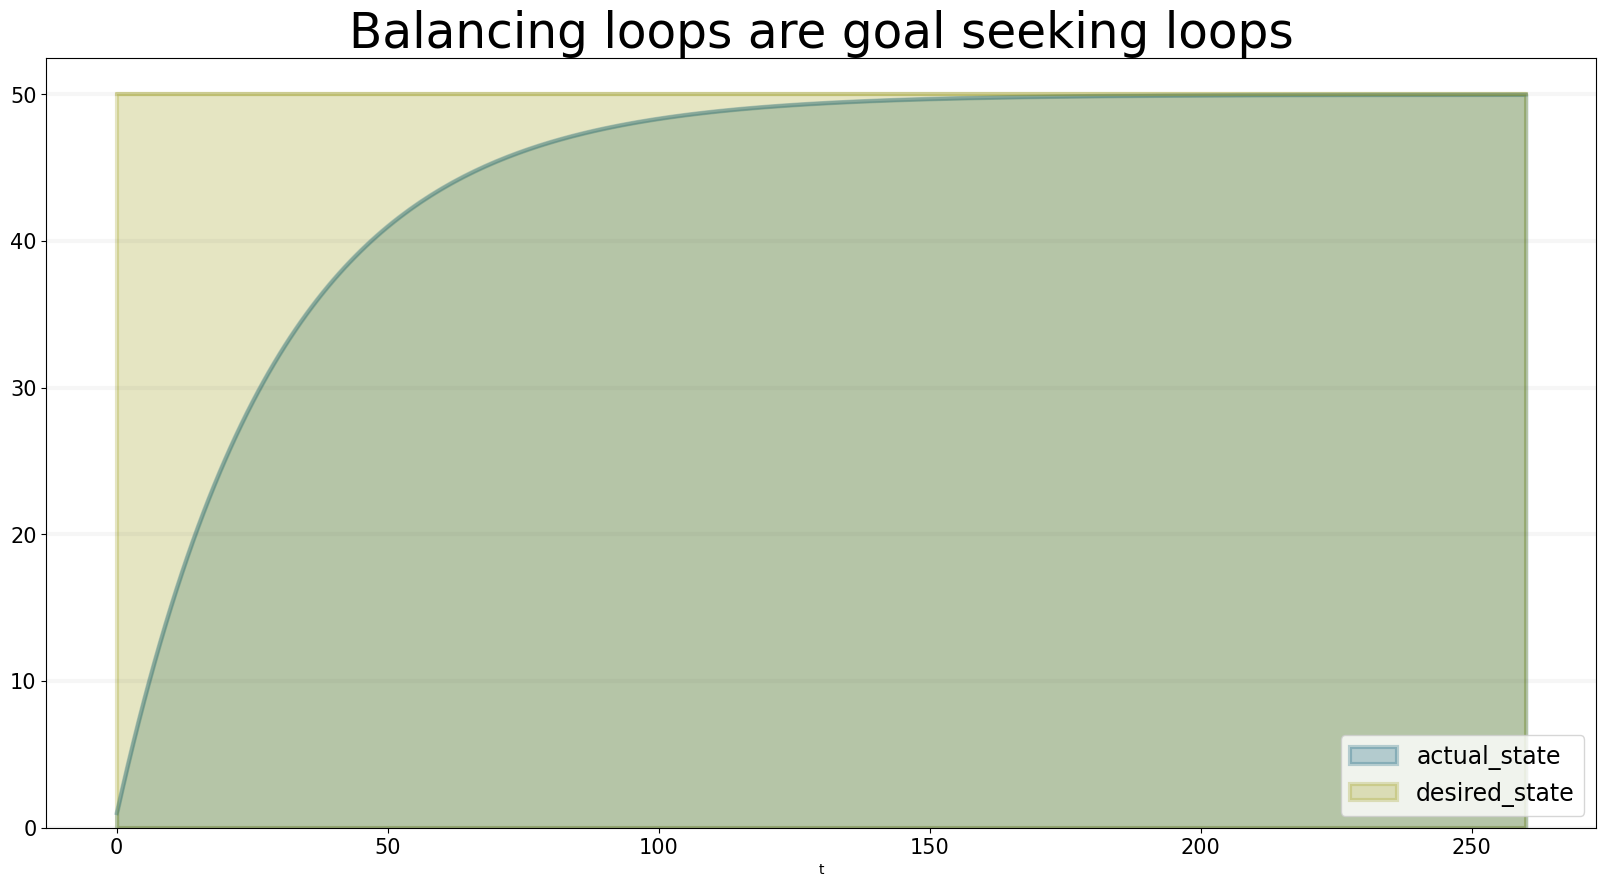

In [7]:
bptk.plot_scenarios(
    title="Balancing loops are goal seeking loops",
    scenario_managers=["smBalancing"],
    scenarios=["base"],
    equations=["actual_state","desired_state"])

The actual state slowly adjust to the desired state - note that it takes much longer then 40 weeks to adjust to the desired state: the size of the action depends on the size of the gap, as the gap gets smaller, so does the size of the action.

Now let's take a look at what happens when we adjust the delays - in the next scenario, we assume all delays are equal to 10 weeks.

In [8]:
bptk.register_scenarios(
    scenario_manager="smBalancing",
    scenarios={
    "oscillations":{
        "constants":{
            "adjustment_time":12.0,
            "measurement_delay":4.0,
            "decision_delay":4.0,
            "action_delay":4.0
        }
    }
    }
)

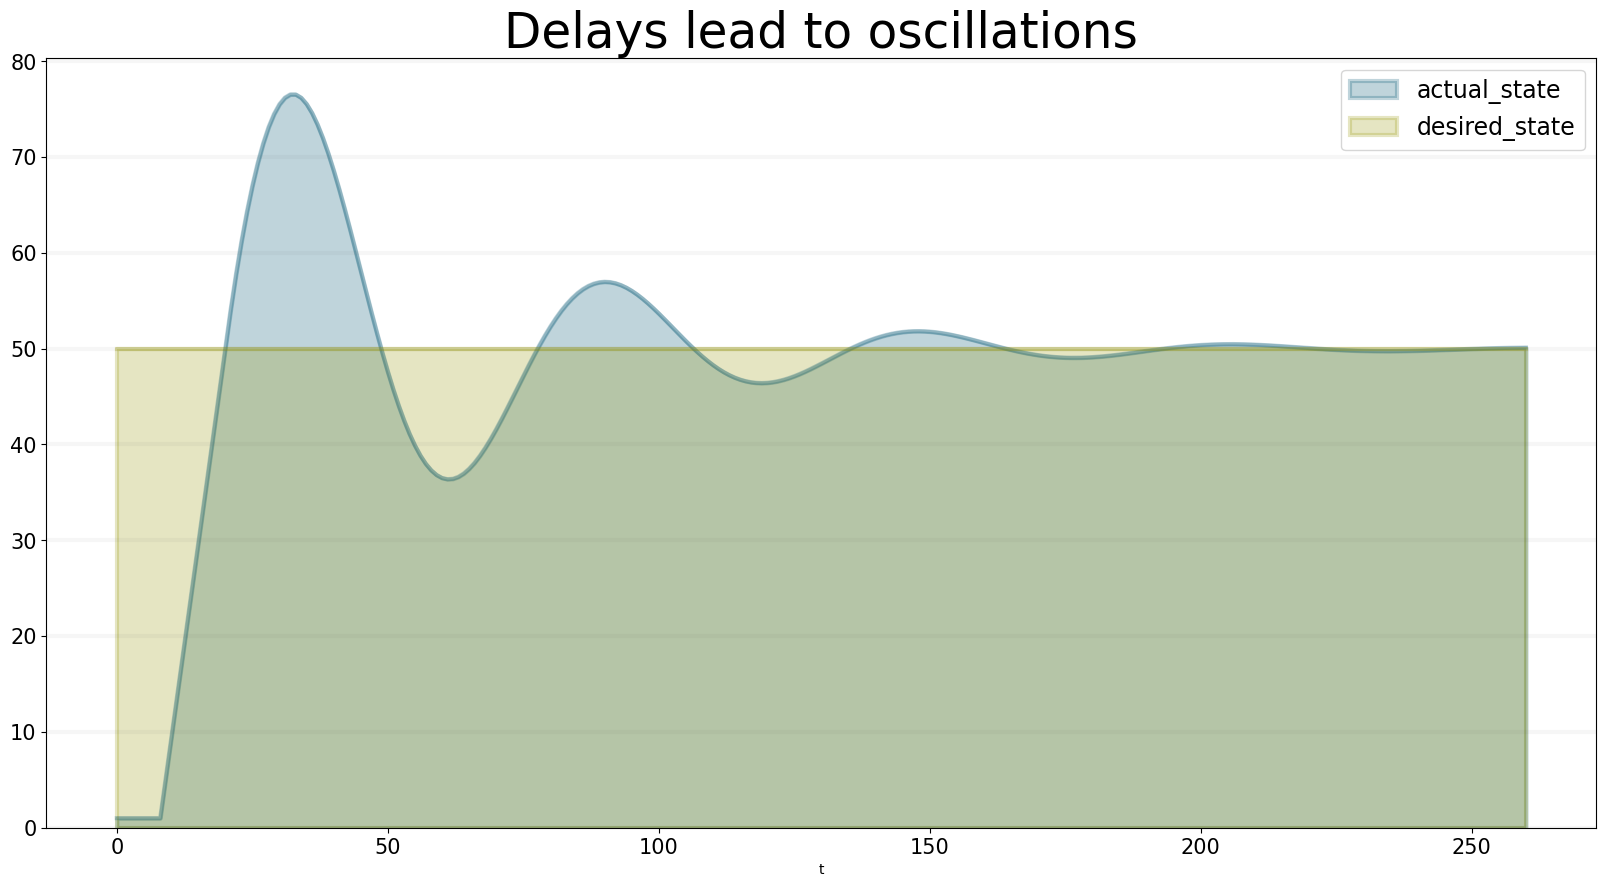

In [9]:
bptk.plot_scenarios(
    title="Delays lead to oscillations",
    scenario_managers=["smBalancing"],
    scenarios=["oscillations"],
    equations=["actual_state","desired_state"])

In this scenario we see oscillating behavior: first it takes quite some time for any change in the actual state. Because of the delay in the observation of the actual state, we take to much action and overshoot the goal: the actual state becomes bigger than the desired state.

The system then corrects its action downwards, but again the desired state is overshot and the actual state ends up being to small. The oscillations dampen down, but we can see it will take some time for the system to adjust.

## Experimeting with the Balancing Feedback Archetype

The dashboard below let's you experiment with different settings for delays and adjustment times.

In [10]:
from BPTK_Py.visualizations import SimpleDashboard
import ipywidgets as widgets

bptk.register_scenarios(
    scenario_manager="smBalancing",
    scenarios={
    "interactive":{}
    }
)

dashboard = SimpleDashboard(bptk, scenario_manager="smBalancing", scenario="interactive")

In [11]:
wdg_adjustment_time_slider = widgets.FloatSlider(
    min=1.0, 
    max=100.0, 
    value=12.0, 
    step=1.0
)

wdg_measurement_delay_slider=widgets.FloatSlider(
    min=0.0,
    max=4.0,
    value=0.0,
    step=1.0
)

wdg_decision_delay_slider=widgets.FloatSlider(
    min=0.0,
    max=4.0,
    value=0.0,
    step=1.0
)

wdg_action_delay_slider=widgets.FloatSlider(
    min=0.0,
    max=4.0,
    value=0.0,
    step=1.0
)

In [12]:
dashboard.add_widget(wdg_adjustment_time_slider, "adjustment_time")
dashboard.add_widget(wdg_measurement_delay_slider, "measurement_delay")
dashboard.add_widget(wdg_decision_delay_slider, "decision_delay")
dashboard.add_widget(wdg_action_delay_slider, "action_delay")

plot = dashboard.add_plot(
    equations=["actual_state","desired_state"], 
    names=["Actual State","Desired State"],
    title="Experimenting with Balancing Feedback Loops",
    x_label="Week",
    y_label="State",
)

controls = widgets.HBox([
    widgets.VBox([
        widgets.Label("Adjustment Time"),
        widgets.Label("Measurement Delay"),
        widgets.Label("Decision Delay"),
        widgets.Label("Action Delay")
    ]),
    widgets.VBox([
    wdg_adjustment_time_slider,
    wdg_measurement_delay_slider,
    wdg_decision_delay_slider,
    wdg_action_delay_slider
    ])
]
)


display(plot)
display(controls)
dashboard.start()

Output()